[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/benjaminlarkey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


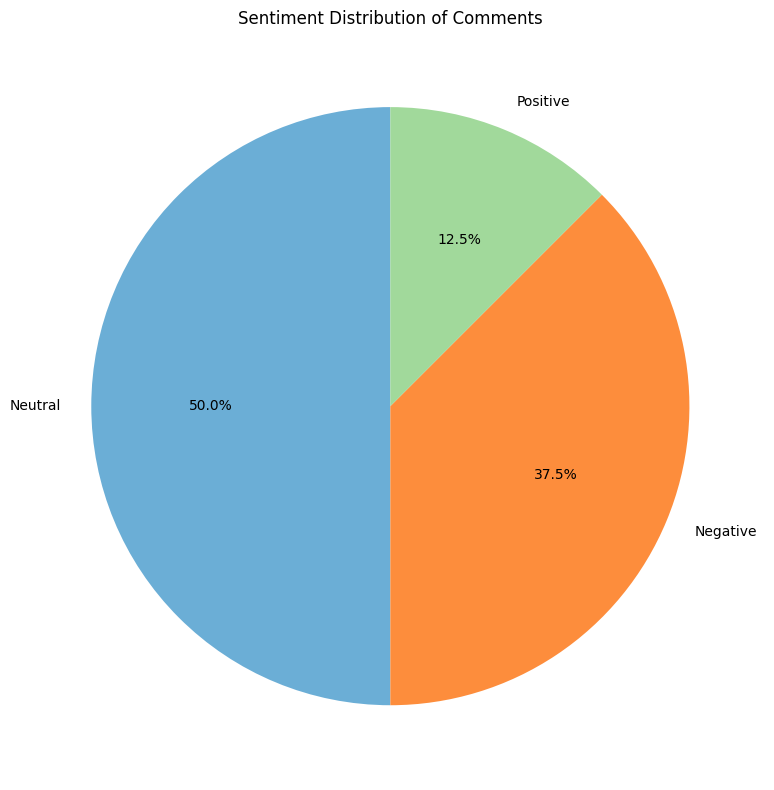

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from datetime import datetime

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def analyze_stock_sentiment(file_path, cutoff_date, date_format="%Y-%m-%d %H:%M:%S"):
    # Convert cutoff date to UNIX timestamp
    cutoff_time = datetime.strptime(cutoff_date, date_format).timestamp()
    
    # Load the data
    stock_data = pd.read_csv(file_path)
    
    # Ensure the 'created_utc' column exists and is numeric
    if 'created_utc' not in stock_data.columns or not pd.api.types.is_numeric_dtype(stock_data['created_utc']):
        raise ValueError("The CSV must contain a 'created_utc' column with UNIX timestamps.")
    
    # Filter comments based on cutoff time
    stock_data = stock_data[stock_data['created_utc'] < cutoff_time]
    
    # Ensure the 'comment' column exists
    if 'comment' not in stock_data.columns:
        raise ValueError("The CSV must contain a 'comment' column with text data.")
    
    # Analyze sentiment for each comment
    def analyze_sentiment(comment):
        sentiment = sia.polarity_scores(comment)
        compound_score = sentiment['compound']
        if compound_score > 0.05:
            return "Positive"
        elif compound_score < -0.05:
            return "Negative"
        else:
            return "Neutral"
    
    stock_data['sentiment'] = stock_data['comment'].apply(lambda x: analyze_sentiment(str(x)))
    
    # Get sentiment counts
    sentiment_counts = stock_data['sentiment'].value_counts()
    
    # Generate a pie chart
    plt.figure(figsize=(8, 8))
    sentiment_counts.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        labels=sentiment_counts.index,
        colors=['#6baed6', '#fd8d3c', '#a1d99b']
    )
    plt.title("Sentiment Distribution of Comments")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'data/tgt.csv'
cutoff_date = "2024-11-18 23:00:00"
analyze_stock_sentiment(file_path, cutoff_date)



In [79]:
import os
import requests

def make_url(ticker_symbol):
    """Generate the URL for retrieving stock data."""
    return f"http://ichart.finance.yahoo.com/table.csv?s={ticker_symbol}"

def ensure_directory(directory):
    """Create directory if it doesn't exist."""
    os.makedirs(directory, exist_ok=True)

def make_filename(ticker_symbol, base_dir=".", subdirectory="price_data"):
    # Create full path
    full_dir = os.path.join(base_dir, subdirectory)
    
    # Ensure directory exists
    ensure_directory(full_dir)
    
    # Return full file path
    return os.path.join(full_dir, f"{ticker_symbol}.csv")

def pull_historical_data(ticker_symbol, base_dir=".", subdirectory="S&P"):
    try:
        # Construct URL and filename
        url = make_url(ticker_symbol)
        filename = make_filename(ticker_symbol, base_dir, subdirectory)
        
        # Send GET request
        response = requests.get(url)
        
        # Raise an exception for bad status codes
        response.raise_for_status()
        
        # Write content to file
        with open(filename, 'wb') as file:
            file.write(response.content)
        
        print(f"Successfully downloaded data for {ticker_symbol} to {filename}")
        return True
    
    except requests.RequestException as e:
        print(f"Error downloading data for {ticker_symbol}: {e}")
        return False

# Example usage
if __name__ == "__main__":
    pull_historical_data("INTU")

AttributeError: module 'urllib' has no attribute 'ContentTooShortError'